In [ ]:
import numpy as np


def convert_physical_to_intuitive_params(phys_params):
    """
    物理パラメータを、L=2πを基準とした直感的な最適化パラメータに変換する。
    """
    L_phys = phys_params["L"]
    Lambda_c = phys_params["center_period"]
    dz_phys = phys_params["dz"]
    B_scale = phys_params["bandwidth_scale"]
    A_scale = phys_params["amplitude_scale"]

    fs = int(L_phys / dz_phys)
    target_center_k = L_phys / Lambda_c
    target_bandwidth = 2.0 * B_scale
    target_amplitude = 4.0 * A_scale

    opt_params = {
        "L": 2 * np.pi,
        "A": 1,
        "M": 1000,
        "fs": fs,
        "target_bandwidth": target_bandwidth,
        "target_amplitude": target_amplitude,
        "target_center_k": target_center_k,
    }
    return opt_params

In [2]:
import random
import time
from scipy.signal import czt


class AnsatzStateful:
    def __init__(self, signal, domains, params):
        self.signal = signal
        self.domains = domains
        self.params = params
        self.last_flipped_domain_indices = None

    def mutate(self):
        n_domains = len(self.domains)
        n_half = n_domains // 2
        if n_half < 2:
            return  # 対称反転には少なくとも2つのドメインペアが必要

        start_domain_idx = random.randint(0, n_half - 2)
        end_domain_idx = random.randint(start_domain_idx + 1, n_half - 1)

        self.last_flipped_domain_indices = (start_domain_idx, end_domain_idx)
        self._flip_domains(start_domain_idx, end_domain_idx)

    def revert(self):
        if self.last_flipped_domain_indices:
            start_idx, end_idx = self.last_flipped_domain_indices
            self._flip_domains(start_idx, end_idx)  # 同じ操作を再度行うと元に戻る
            self.last_flipped_domain_indices = None

    def _flip_domains(self, start_domain_idx, end_domain_idx):
        n_domains = len(self.domains)
        # 前半部分のフリップ
        for i in range(start_domain_idx, end_domain_idx + 1):
            start, end = self.domains[i]
            self.signal[start:end] *= -1
        # 対称な後半部分のフリップ
        symmetric_start_idx = n_domains - 1 - end_domain_idx
        symmetric_end_idx = n_domains - 1 - start_domain_idx
        for i in range(symmetric_start_idx, symmetric_end_idx + 1):
            start, end = self.domains[i]
            self.signal[start:end] *= -1


class CostCalculator:
    def __init__(self, params):
        self.params = params
        self._precompute_czt_params()

    def _precompute_czt_params(self):
        L, fs, M = self.params["L"], self.params["fs"], self.params["M"]
        target_center_k, target_bw = self.params["target_center_k"], self.params["target_bandwidth"]
        k_start = target_center_k - target_bw / 2
        k_end = target_center_k + target_bw / 2
        f_norm_start, f_norm_end = k_start / fs, k_end / fs
        self.czt_params = {
            'm': M, 'w': np.exp(-1j * 2 * np.pi * (f_norm_end - f_norm_start) / M),
            'a': np.exp(1j * 2 * np.pi * f_norm_start)}

    def calculate(self, signal):
        L, fs, target_amp = self.params["L"], self.params["fs"], self.params["target_amplitude"]
        spectrum = czt(signal, **self.czt_params) * L / fs
        return np.sum((np.abs(spectrum) - target_amp)**2)


class SimulatedAnnealer:
    def __init__(self, ansatz, calculator, sa_params):
        self.ansatz = ansatz
        self.best_signal = ansatz.signal.copy()
        self.calculator = calculator
        self.sa_params = sa_params
        self.cost_history = []

    def run(self):
        temp, cooling_rate, n_iter = self.sa_params["initial_temp"], self.sa_params[
            "cooling_rate"], self.sa_params["n_iterations"]
        current_cost = self.calculator.calculate(self.ansatz.signal)
        best_cost = current_cost
        self.cost_history.append(best_cost)

        start_time = time.time()
        for i in range(n_iter):
            self.ansatz.mutate()
            neighbor_cost = self.calculator.calculate(self.ansatz.signal)

            if neighbor_cost < current_cost or random.random() < np.exp(-(neighbor_cost - current_cost) / temp):
                current_cost = neighbor_cost
            else:
                self.ansatz.revert()

            if current_cost < best_cost:
                best_cost = current_cost
                self.best_signal = self.ansatz.signal.copy()

            temp *= cooling_rate
            self.cost_history.append(best_cost)

            if (i + 1) % 1000 == 0:
                print(
                    f"Iter {i+1}/{n_iter}, Cost: {best_cost:.4g}, Temp: {temp:.4g}, Time: {time.time() - start_time:.2f}s")
        return self.best_signal


def create_lfm_ansatz(params):
    L, fs, target_center_k, target_bw = params["L"], params[
        "fs"], params["target_center_k"], params["target_bandwidth"]
    k_start, k_end = target_center_k - target_bw / 2, target_center_k + target_bw / 2
    z = np.linspace(-L/2, L/2, fs, endpoint=False)
    inst_phase = k_start * z + (k_end - k_start) / L * (z**2 / 2 + L/2 * z)
    signal = np.sign(np.cos(inst_phase))
    change_points = np.where(np.diff(signal) != 0)[0] + 1
    db = np.concatenate(([0], change_points, [fs]))
    domains = [(int(db[i]), int(db[i+1]))
               for i in range(len(db)-1) if int(db[i]) < int(db[i+1])]
    return AnsatzStateful(signal, domains, params)

Iter 1000/10000, Cost: 4.753, Temp: 3.677, Time: 31.02s
Iter 2000/10000, Cost: 4.753, Temp: 1.352, Time: 62.01s
Iter 3000/10000, Cost: 4.753, Temp: 0.4971, Time: 93.49s
Iter 4000/10000, Cost: 4.753, Temp: 0.1828, Time: 124.77s
Iter 5000/10000, Cost: 4.753, Temp: 0.06721, Time: 156.05s
Iter 6000/10000, Cost: 4.753, Temp: 0.02471, Time: 187.15s
Iter 7000/10000, Cost: 4.753, Temp: 0.009087, Time: 218.52s
Iter 8000/10000, Cost: 4.753, Temp: 0.003341, Time: 249.84s
Iter 9000/10000, Cost: 4.753, Temp: 0.001229, Time: 281.25s
Iter 10000/10000, Cost: 4.753, Temp: 0.0004517, Time: 312.40s


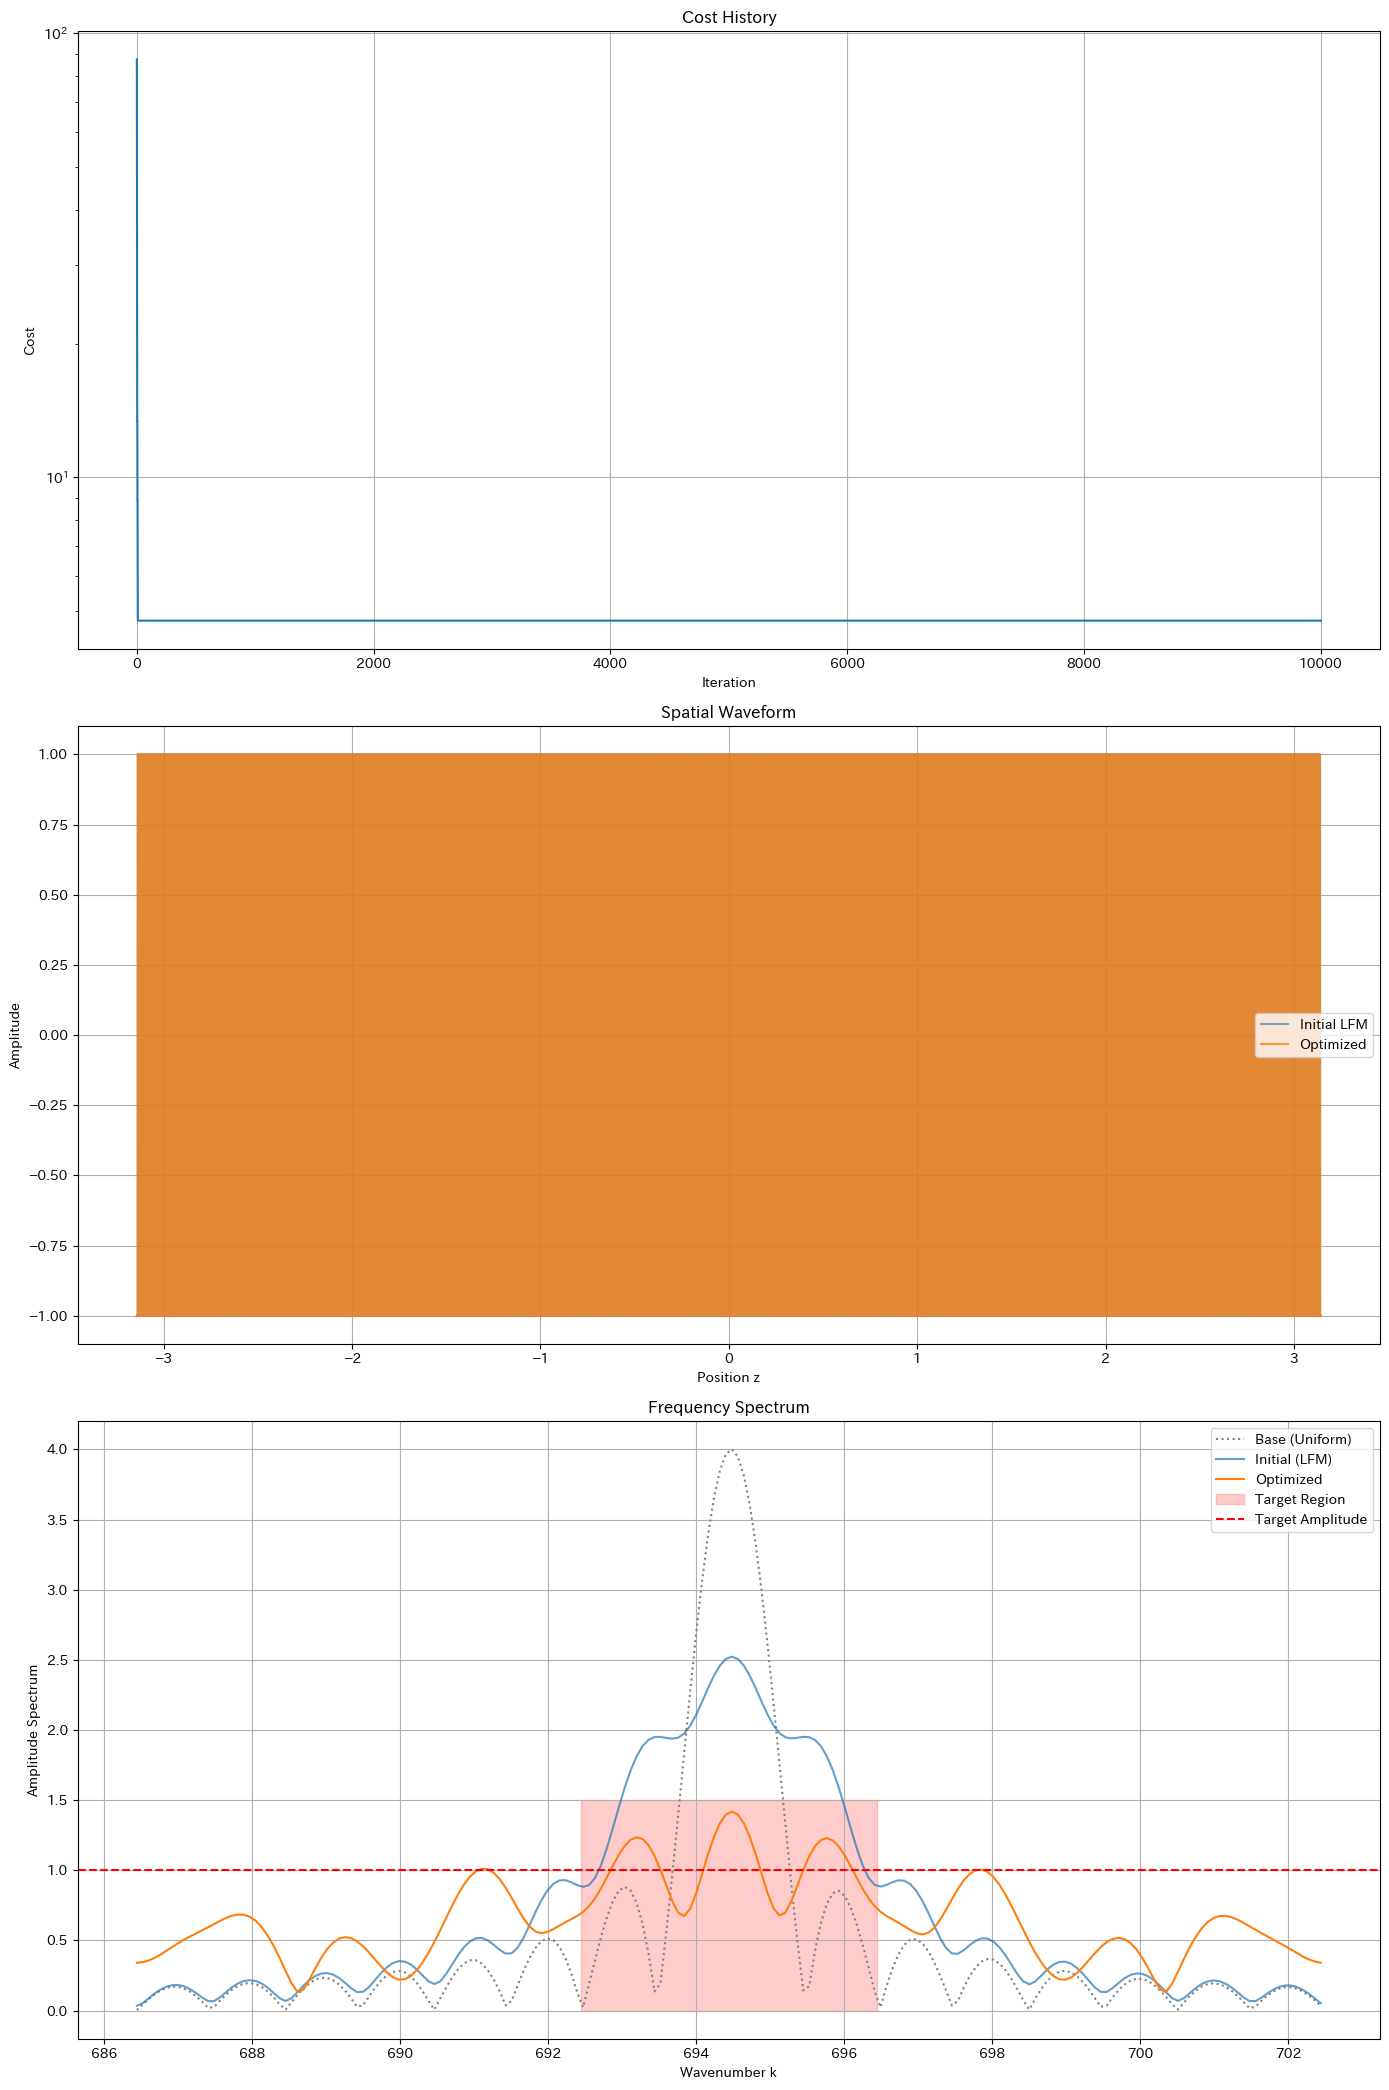

In [3]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# 1. パラメータ設定
physical_parameters = {
    "L": 5e6, "center_period": 7200, "dz": 100,
    "bandwidth_scale": 2, "amplitude_scale": 1/4}
sa_params = {
    "initial_temp": 10.0, "cooling_rate": 0.999, "n_iterations": 10000}

# 2. 最適化問題のパラメータに変換
opt_params = convert_physical_to_intuitive_params(physical_parameters)

# 3. 初期Ansatzと計算機を生成
initial_ansatz = create_lfm_ansatz(opt_params)
initial_signal_copy = initial_ansatz.signal.copy()  # プロット用に初期状態を保存
cost_calculator = CostCalculator(opt_params)

# 4. 焼きなまし法を実行
annealer = SimulatedAnnealer(initial_ansatz, cost_calculator, sa_params)
optimized_signal = annealer.run()

# 5. 結果をプロット


def plot_final_results(initial_sig, optimized_sig, params, cost_history):
    fig, axes = plt.subplots(3, 1, figsize=(14, 21))
    L, fs, M = params["L"], params["fs"], params["M"]
    target_center_k, target_bw, target_amp = params["target_center_k"], params[
        "target_bandwidth"], params["target_amplitude"]

    # コスト履歴
    axes[0].plot(cost_history)
    axes[0].set_title('Cost History')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Cost')
    axes[0].set_yscale('log')
    axes[0].grid(True)

    # 空間波形
    z = np.linspace(-L/2, L/2, fs, endpoint=False)
    axes[1].plot(z, initial_sig, label='Initial LFM', alpha=0.6)
    axes[1].plot(z, optimized_sig, label='Optimized', alpha=0.8)
    axes[1].set_title('Spatial Waveform')
    axes[1].set_xlabel('Position z')
    axes[1].set_ylabel('Amplitude')
    axes[1].legend()
    axes[1].grid(True)

    # 周波数スペクトル
    k_view_width = target_bw * 2
    k_start_view, k_end_view = target_center_k - \
        k_view_width, target_center_k + k_view_width
    f_norm_start_view, f_norm_end_view = k_start_view / fs, k_end_view / fs
    view_czt_params = {'m': M*2, 'w': np.exp(-1j*2*np.pi*(
        f_norm_end_view-f_norm_start_view)/(M*2)), 'a': np.exp(1j*2*np.pi*f_norm_start_view)}
    k_axis_view = np.linspace(k_start_view, k_end_view, M*2)

    base_signal = np.sign(np.cos(target_center_k * z))
    base_spec = np.abs(czt(base_signal, **view_czt_params) * L / fs)
    initial_spec = np.abs(czt(initial_sig, **view_czt_params) * L / fs)
    optimized_spec = np.abs(czt(optimized_sig, **view_czt_params) * L / fs)

    axes[2].plot(k_axis_view, base_spec, label='Base (Uniform)',
                 linestyle=':', color='gray')
    axes[2].plot(k_axis_view, initial_spec, label='Initial (LFM)', alpha=0.7)
    axes[2].plot(k_axis_view, optimized_spec, label='Optimized')
    k_min_target, k_max_target = target_center_k - \
        target_bw / 2, target_center_k + target_bw / 2
    axes[2].fill_between([k_min_target, k_max_target], 0, target_amp *
                         1.5, color='red', alpha=0.2, label='Target Region')
    axes[2].axhline(y=target_amp, color='r', linestyle='--',
                    label='Target Amplitude')
    axes[2].set_title('Frequency Spectrum')
    axes[2].set_xlabel('Wavenumber k')
    axes[2].set_ylabel('Amplitude Spectrum')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


plot_final_results(initial_signal_copy, optimized_signal,
                   opt_params, annealer.cost_history)